In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import os
from glob import glob

from path import Path

from numpy import mean
from numpy import std

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

from keras.optimizers import Adam

import random

from keras.utils import to_categorical


Using TensorFlow backend.


## Load Data

In [2]:
def filter_active_keypoints(frame_df):
    #active_keypoints = [0, 1, 8, 2, 3, 4, 5, 6, 7] # trunk
    
    active_keypoints = [0, 1, 8, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
    
    #filtered_df  = frame_df[frame_df.index.isin(active_keypoints)]
    filtered_df = frame_df

    return filtered_df

def get_frame_data(filepath):
    frame_data = pd.read_csv(filepath)
    
    x_data = filter_active_keypoints(frame_data.iloc[:, 0])
    y_data = filter_active_keypoints(frame_data.iloc[:, 1])
    
    #print(f"x_data shape: {x_data.shape}")
    #print(f"y_data shape: {y_data.shape}")
        
    h_stacked = np.hstack((x_data, y_data))
    #h_stacked = np.hstack((y_data))
    
    return h_stacked

def get_frame_file_path(frame_file_path_template, frame_idx):
    frame_file_path = frame_file_path_template.replace("[frame_idx]", str(frame_idx))
    return frame_file_path

def get_label(sample_dir_name):
    return 0 if sample_dir_name[0] == 'b' else 1

def get_y_labels(sample_dir_names):
    return [get_label(l) for l in sample_dir_names]

def get_frames_count(root_path, sample_dir_name):
    return len([Path(f).abspath() for f in glob(f"{root_path}/{sample_dir_name}" + '/*')])

def get_frames(root_path, sample_dir_name):
    frames = []
    for frame_idx in range(0, get_frames_count(root_path, sample_dir_name)):
        frame_file_path_template = f"{root_path}/{sample_dir_name}/{sample_dir_name}.mov-[frame_idx]-0.csv"
        frame_file_path = get_frame_file_path(frame_file_path_template, frame_idx)
        frame_data = get_frame_data(frame_file_path)
        
        frames.append(frame_data)
        
    return np.dstack(frames)

def get_sample_idx_by_frames_count(frames_count, samples):
    sample_idx = 0
    
    for sample in samples:
        if len(sample) == frames_count:
            return sample_idx
        sample_idx = sample_idx + 1

def get_sample_name_by_frames_count(frames_count, samples, sample_dir_names):
    sample_idx = get_sample_idx_by_frames_count(frames_count, samples)
    return sample_dir_names[sample_idx]

In [3]:
root_path = "/Users/allarviinamae/EduWorkspace/openpose-jupyter-data-exploration/centered-keypoints"

sample_dir_names = [n for n in os.listdir(root_path) if os.path.isdir(f"{root_path}/{n}")]

# ['backflip-40-margus',
# 'flack-31-rasmus',
# 'flack-19-rasmus',

In [4]:
y_labels = get_y_labels(sample_dir_names) # classifier labels, where 0 = backflip and 1 = flack

# [0,
# 1,
# 1,

In [5]:
samples = []
for sample_dir_name in sample_dir_names:
    frames = get_frames(root_path, sample_dir_name)
    squeezed = np.squeeze(frames)
    axes_swapped = np.swapaxes(squeezed, 0, 1)
    samples.append(axes_swapped)

In [6]:
shortest_sample = min([len(sample) for sample in samples])
longest_sample = max([len(sample) for sample in samples])

print(f"Shortest samples {shortest_sample}, longest sample {longest_sample}")

print(len(samples), samples[1].shape, len(y_labels))

Shortest samples 77, longest sample 110
113 (96, 50) 113


Text(0, 0.5, 'Samples')

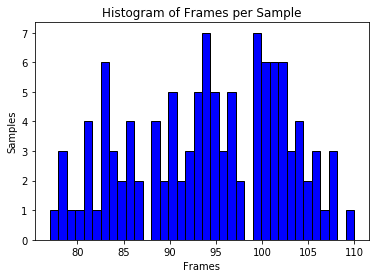

In [7]:
plt.hist([len(sample) for sample in samples], color = 'blue', edgecolor = 'black', bins = int(180/5))

# Add labels
plt.title('Histogram of Frames per Sample')
plt.xlabel('Frames')
plt.ylabel('Samples')

In [8]:
get_sample_name_by_frames_count(110, samples, sample_dir_names)

'backflip-50-joosep'

## Fit and Evaluate Model

In [9]:
y_labels_stacked = np.dstack(y_labels)
y_labels_categorical = to_categorical(y_labels_stacked) 
y_labels_squeezed = np.squeeze(y_labels_categorical)
print(f"All labels shape {y_labels_squeezed.shape}")

for idx, y_label_squeezed in enumerate(y_labels_squeezed):
    if idx == 5:
        break
    print(f"y_label_squeezed categorical: {y_label_squeezed}")

All labels shape (113, 2)
y_label_squeezed categorical: [1. 0.]
y_label_squeezed categorical: [0. 1.]
y_label_squeezed categorical: [0. 1.]
y_label_squeezed categorical: [0. 1.]
y_label_squeezed categorical: [1. 0.]


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, y_labels_squeezed, test_size=0.2)

print(f"X_train len {len(X_train)}, y_train len {len(y_train)}")
print(f"X_test len {len(X_test)}, y_test len {len(y_test)}")

X_train len 90, y_train len 90
X_test len 23, y_test len 23


In [11]:
def train_generator(samples, y_labels):
    while True:
        random.shuffle(samples)

        for idx, sample in enumerate(samples):
            (frames, features) = sample.shape
        
            sequence_length = frames
            x_train = sample
            y_train = y_labels[idx]
        
            x_train = x_train.reshape(1, frames, features)
            y_train = y_train.reshape(1, 2)            
        
            yield x_train, y_train

In [12]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs = 1, 10
    
    n_features = 50
    n_outputs = 2
    n_steps_per_epoch = len(trainX)
    n_steps_per_epoch = 360
    
    lstm_units = 100
    
    optimizer = Adam(lr=0.001)
        
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(None, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(lstm_units, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    print(model.summary())
    # fit network
    model.fit_generator(train_generator(trainX, trainy), steps_per_epoch=n_steps_per_epoch, epochs=epochs, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate_generator(train_generator(testX, testy), steps=len(testX), verbose=0)
    
    return accuracy

In [13]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [14]:
# run an experiment
def run_experiment(repeats=5):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        score = score * 100.0
        print('>#%d validation accuracy: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

In [ ]:
run_experiment()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 70,702
Trainable params: 70,702
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
360/360 [==============================] - 16s 46ms/step - loss: 0.7807 - accuracy: 0.4833
Epoch 2/10
360/360 [==============================] - 16s 44ms/step - loss: 0.7677 - accuracy: 0.4806
Epoch 3/10
360/360 [===================